In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import glob
from pathlib import Path
from astropy.io import fits
from scipy.optimize import curve_fit
from scipy.interpolate import griddata

class readerFile:

    def __init__(self, file_path):
        self.file_path = file_path
        header, data = self.__read_file()

        hdu = fits.PrimaryHDU(data)
        self.__get_header_format(header, hdu)

        hdul = fits.HDUList([hdu])
        # self.header = header
        self.hdul = hdul

    def read(self):
        return self.hdul


    def __read_file(self):
        header = []

        with open(self.file_path, 'r') as file:
            lines = file.readlines()

            # Skip the first empty line
            lines = lines[1:]  # Skip first empty line

            # Now separate the header and content
            header_found = False
            for i, line in enumerate(lines):
                if header_found:
                    break
                elif line.strip() == '':  # Empty line indicates end of header
                    header_found = True
                else:
                    header.append(line.strip())

        data = np.genfromtxt(self.file_path, unpack=True, skip_header=107)
        return header, data

    def __parse_value(self, value):
        """Parse the string value to the appropriate type (float, int, or str)."""
        value_stripped = value.strip()  # Remove any leading/trailing whitespace
        # Try converting to an int first
        if value_stripped.isdigit():  # Check if it's a positive integer
            return int(value_stripped)
        # Try converting to a float next
        try:
            return float(value_stripped)
        except ValueError:
            return value_stripped  # Return as string if not float or int


    def __get_header_format(self, header, hdu):

        for line in header:
            param_name, param_val = line.split(':')
            parsed_value = self.__parse_value(param_val)

            hdu.header[param_name] = parsed_value

        return

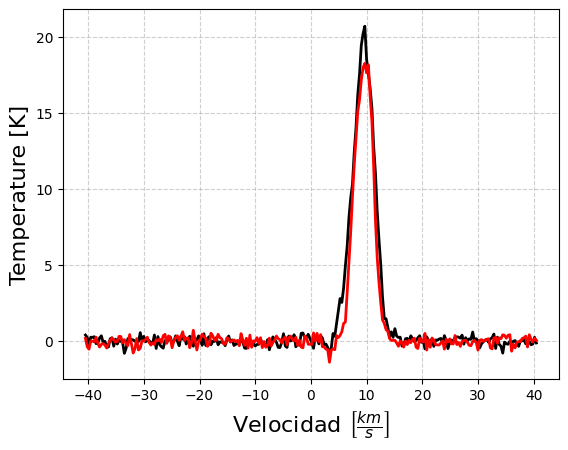

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  256                                                  
NAXIS2  =                    2                                                  
EXTEND  =                    T                                                  
FMT     =                   15                                                  
SOURCENM= 'Orion   '                                                            
COMNT   = ''                                                                    
OBSNAME = 'AE      '                                                            
ISCAN   =                125.0                                                  
QUALITY =                    0                                                  
YEAR    =                 20

In [3]:
spec_data = []
for i in range(5):
    mypath = "/content/drive/MyDrive/datos_espectros/pos " + str(i + 1) + "/sdf*"
    spec_path = sorted(glob.glob(mypath))
    spec_pos = []
    for j in spec_path:
        spec_j = readerFile(j).read()
        spec_pos += spec_j
    for j, i in enumerate(spec_pos):
        hdr = i.header
        v, T = i.data
        lii, bii = hdr['LII'], hdr['BII']
        data = (lii, bii, v, T)
        spec_pos[j] = data
    spec_data.append(spec_pos)

# spec_data[2][0][:2]
#

plt.plot(spec_data[0][0][2], spec_data[0][0][3], color="black", linestyle="-", linewidth=2)
plt.plot(spec_data[1][0][2], spec_data[1][0][3], color="red", linestyle="-", linewidth=2)
plt.xlabel(r"Velocidad $\left[ \frac{km}{s}\right]$", fontsize=16)
plt.ylabel(r"Temperature [K]", fontsize=16)

plt.grid(True, linestyle="--", alpha=0.6)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

hdr

In [4]:
spec_vT_means = []
for i in spec_data:
    spec_T = np.array([el[3] for el in i])
    spec_v = np.array([el[2] for el in i])

    l = len(spec_T)

    sums_T = np.cumsum(np.stack(spec_T), axis = 0)
    sums_v = np.cumsum(np.stack(spec_v), axis = 0)
    div = np.linspace(1, l, l).reshape(-1, 1)

    means_T = sums_T/div
    means_v = sums_v/div

    vT_pos = []
    for j, k in zip(means_v, means_T):
        vT = (j, k)
        vT_pos.append(vT)
    spec_vT_means.append(vT_pos)

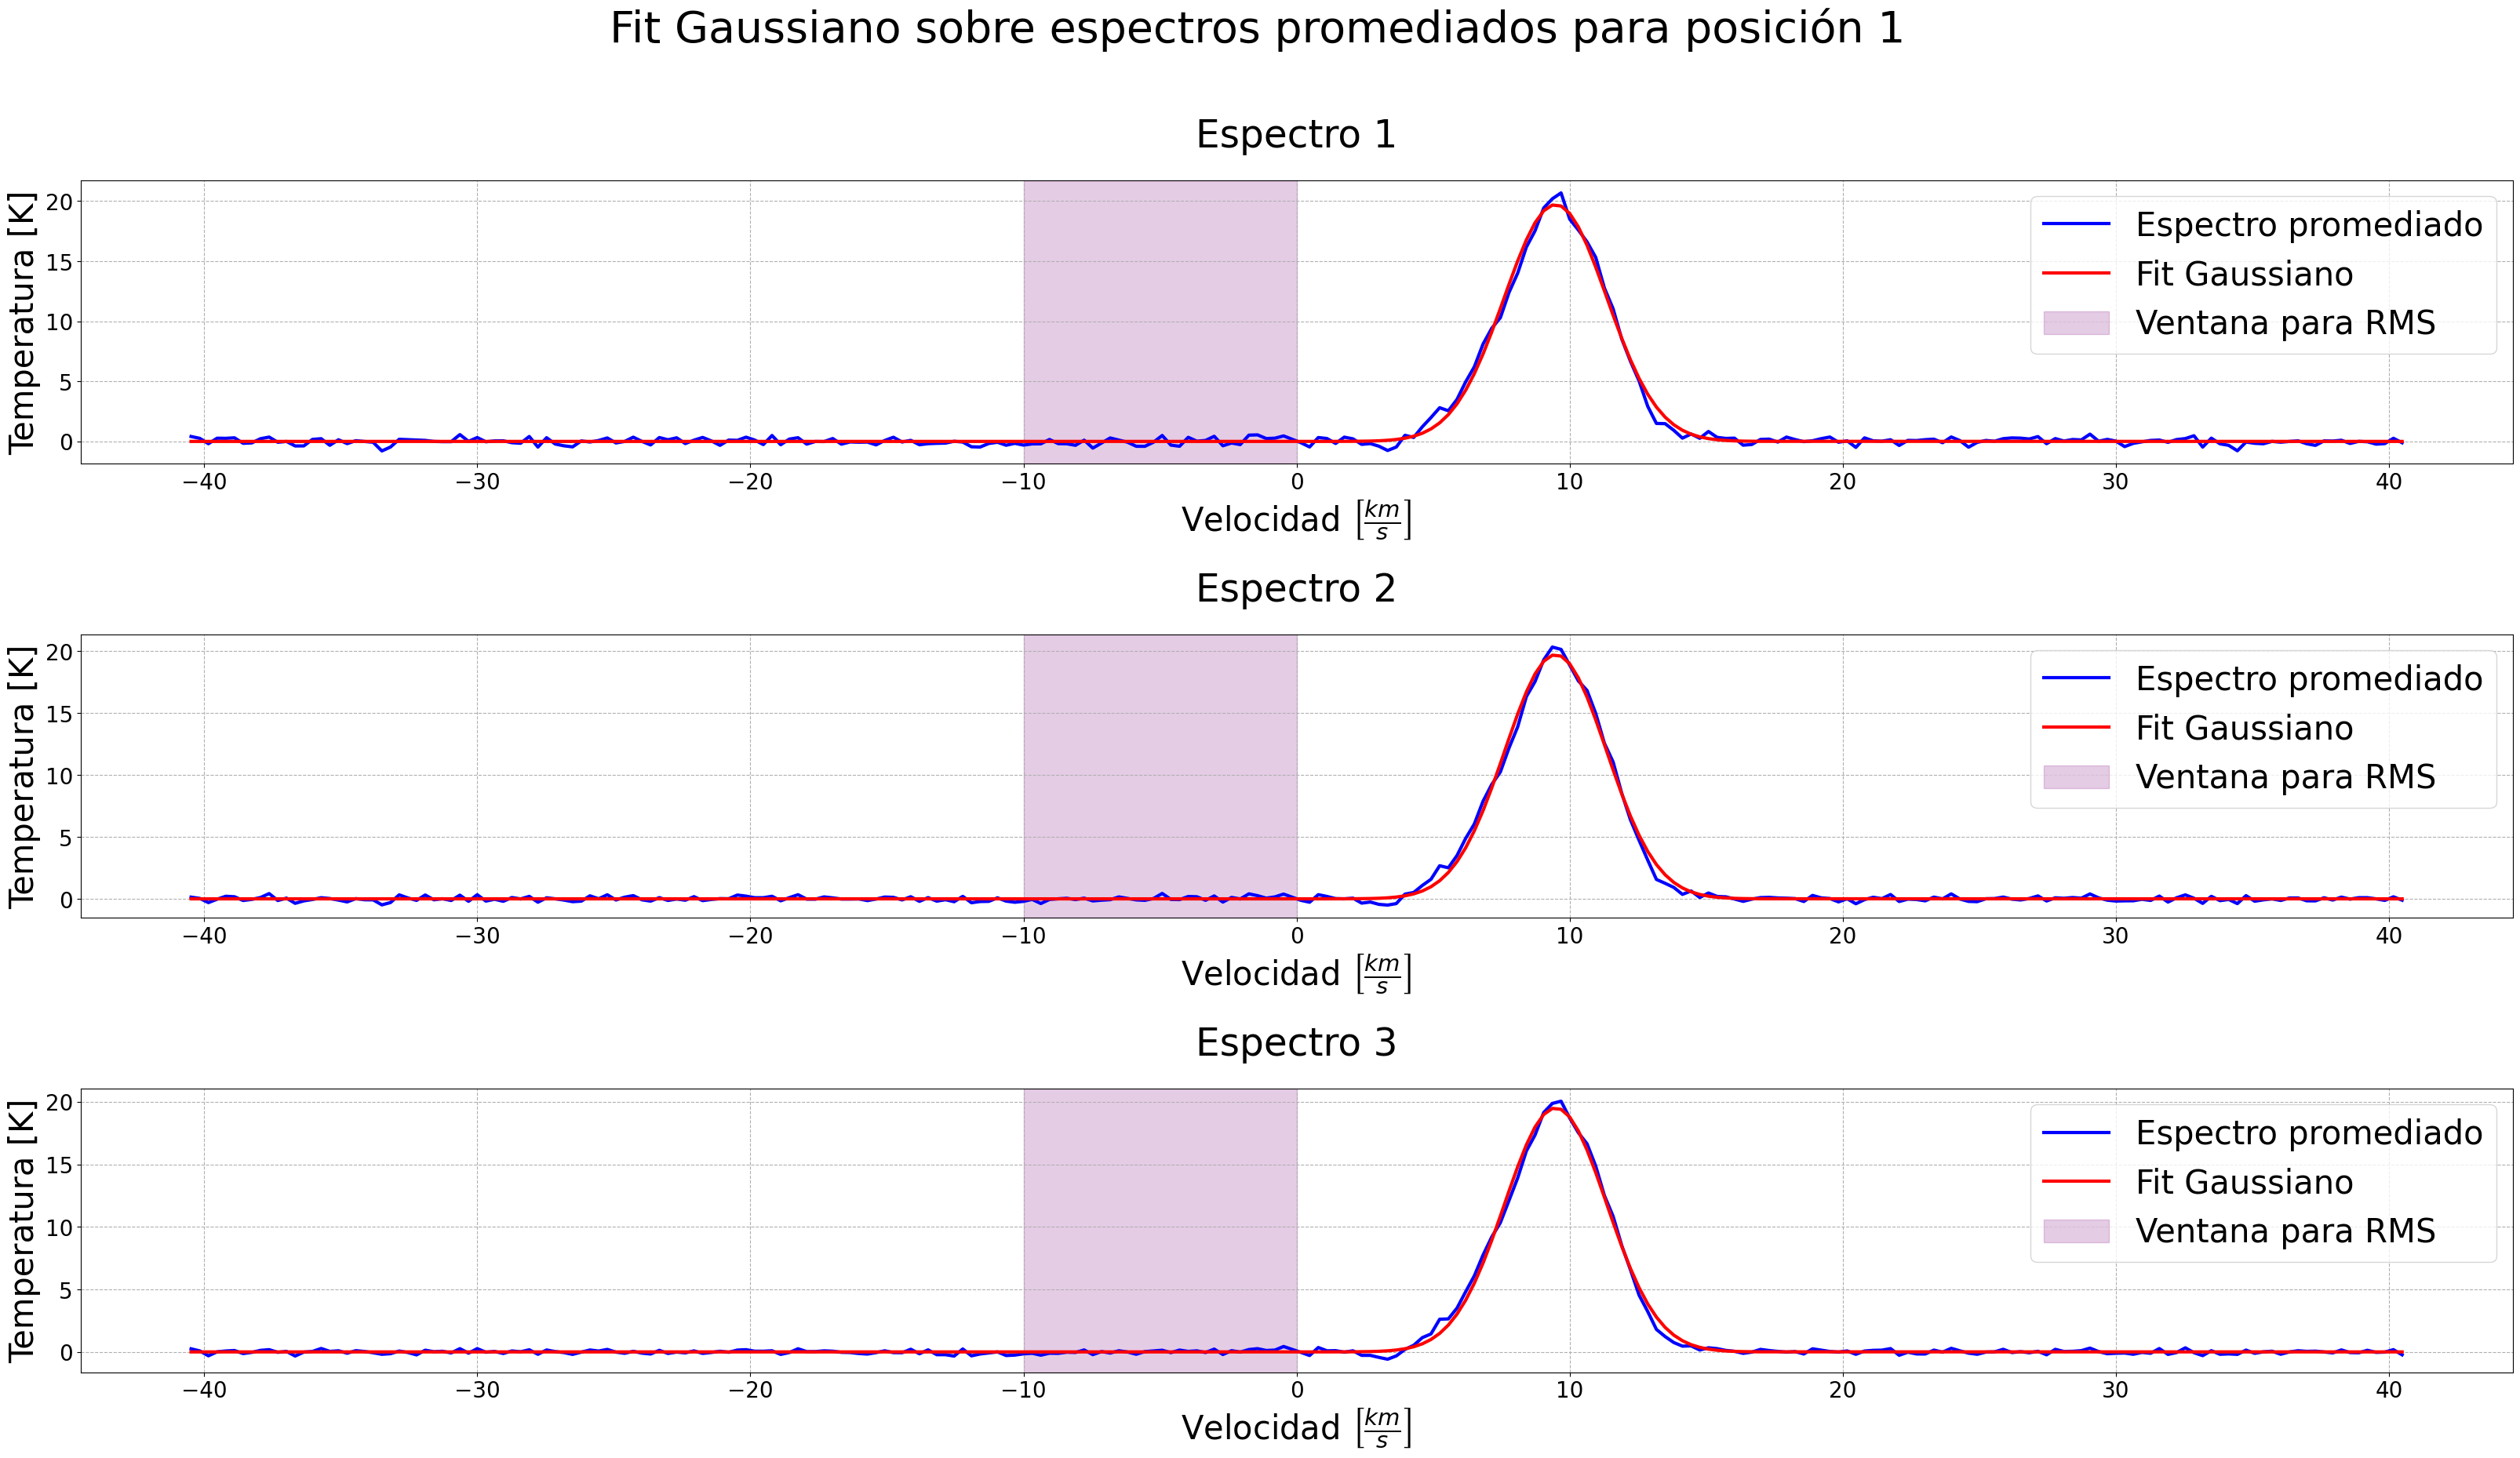

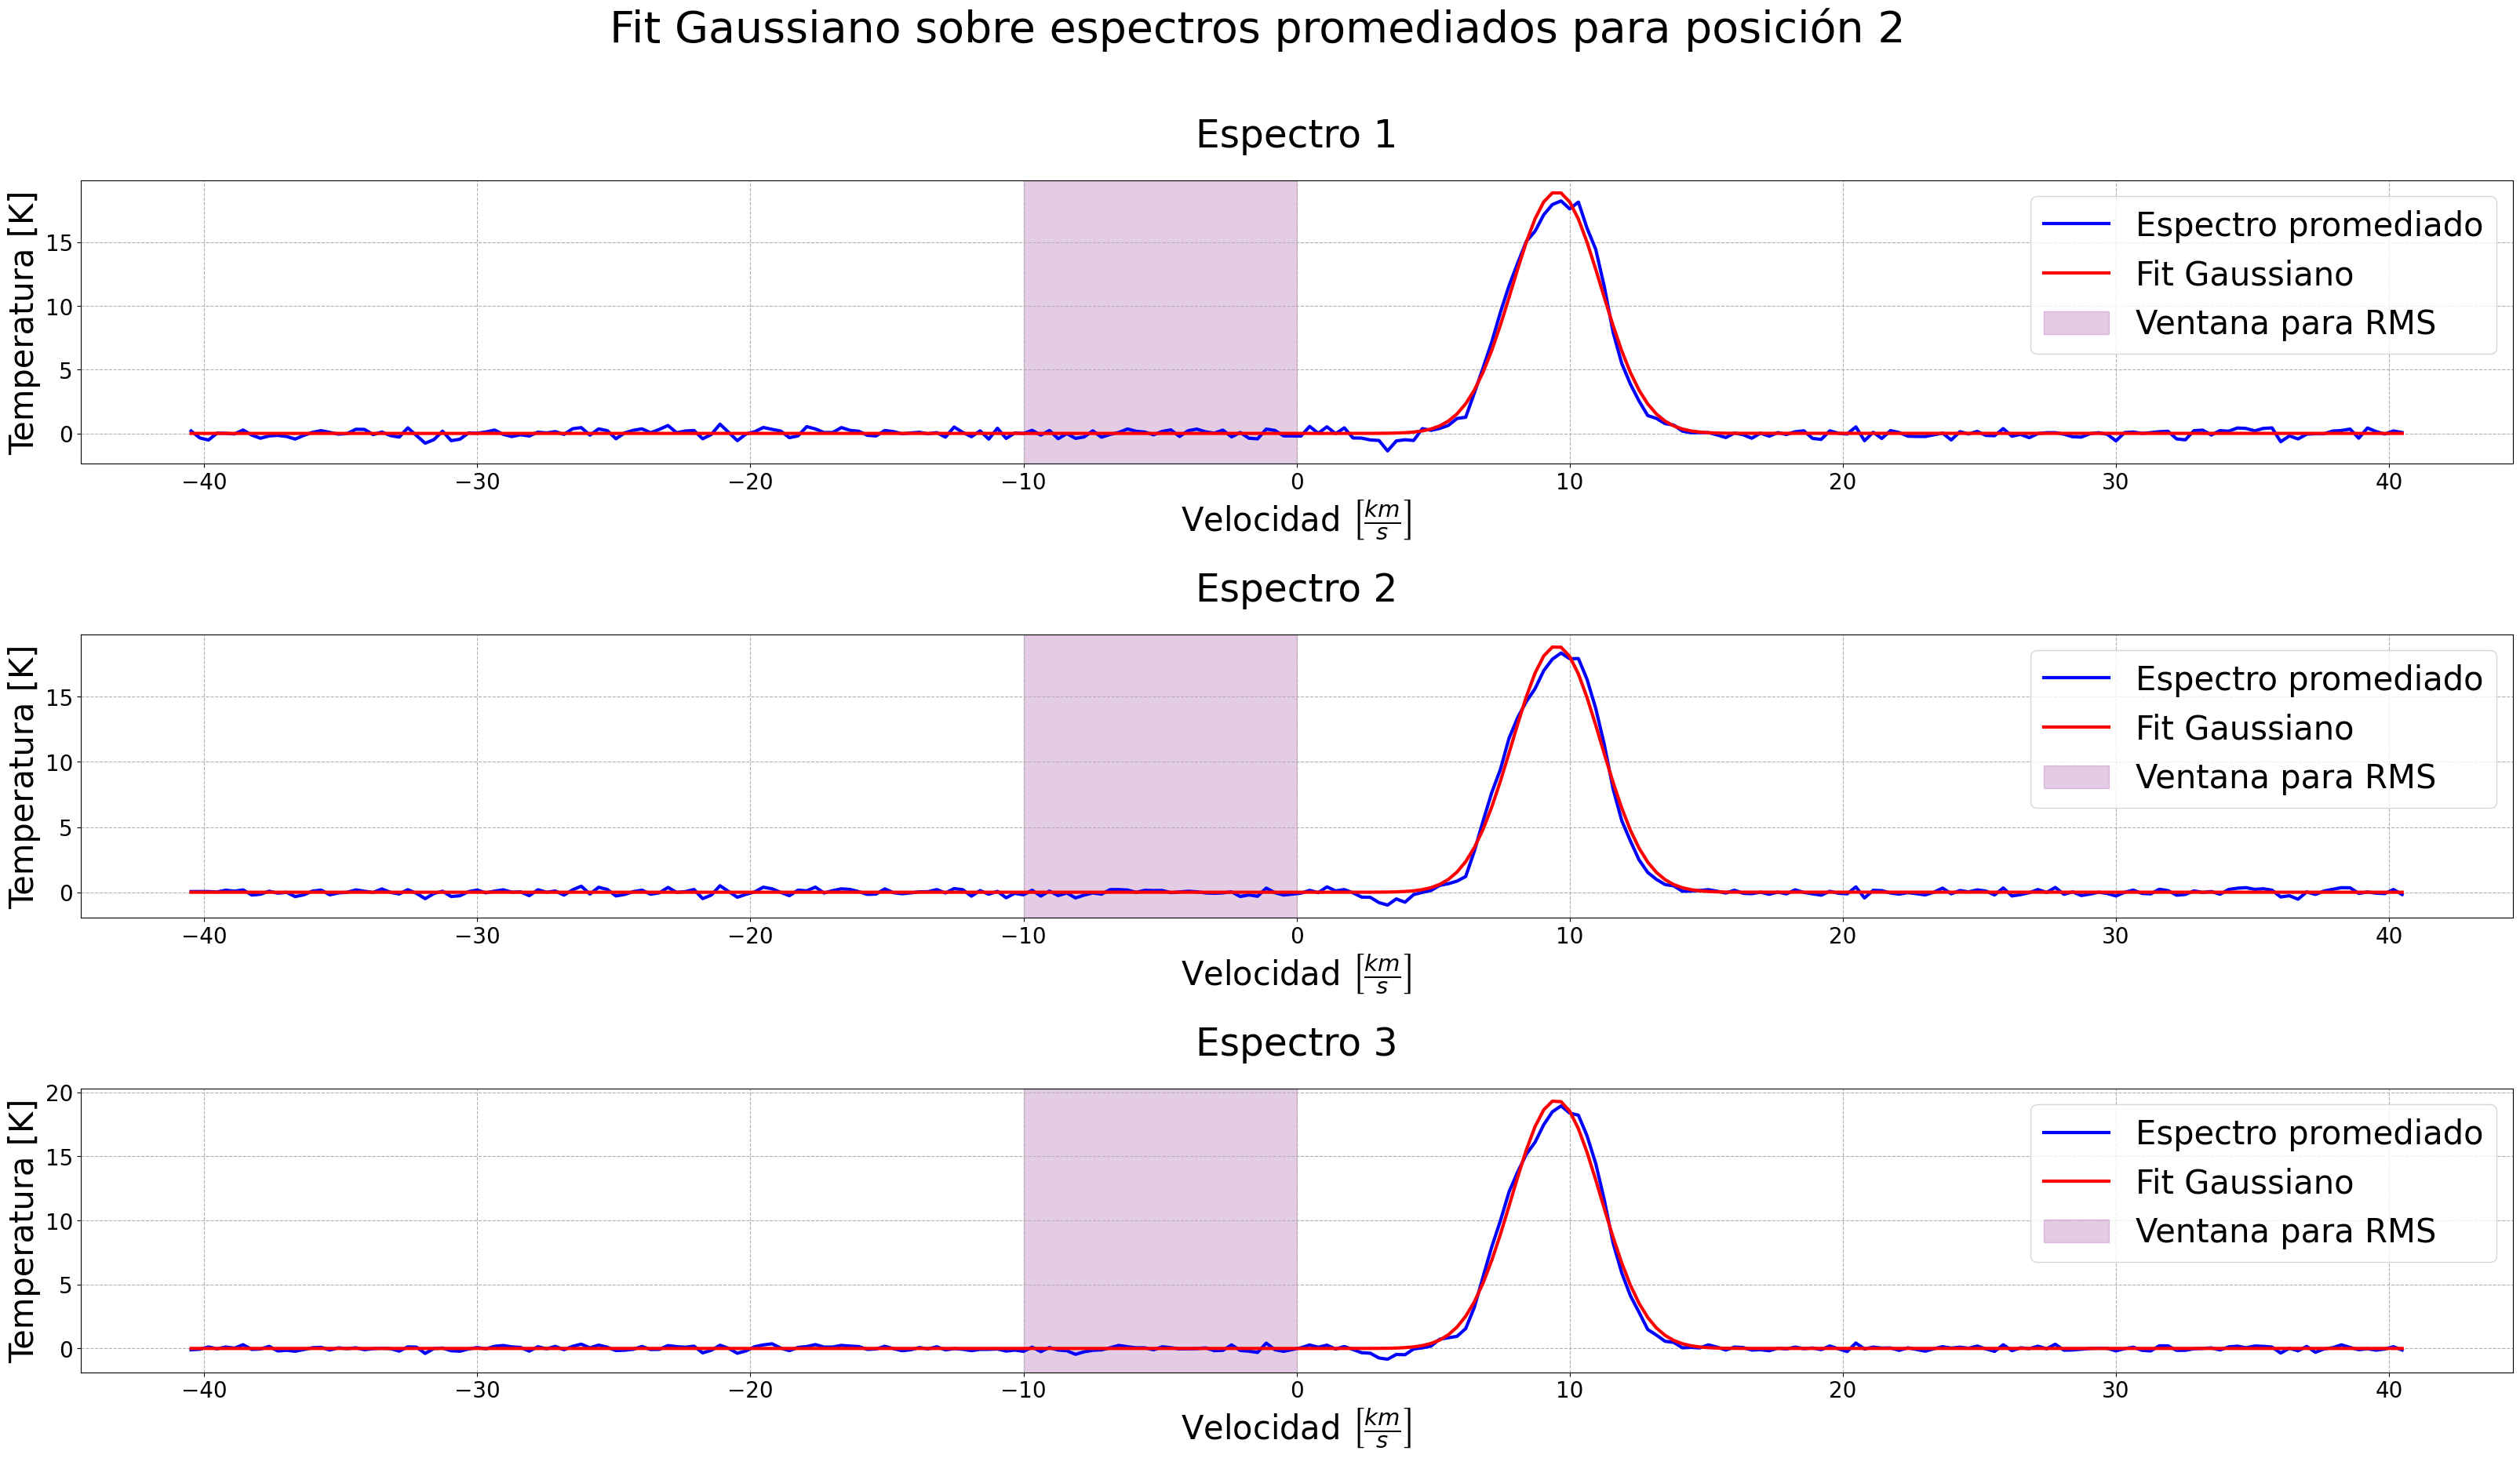

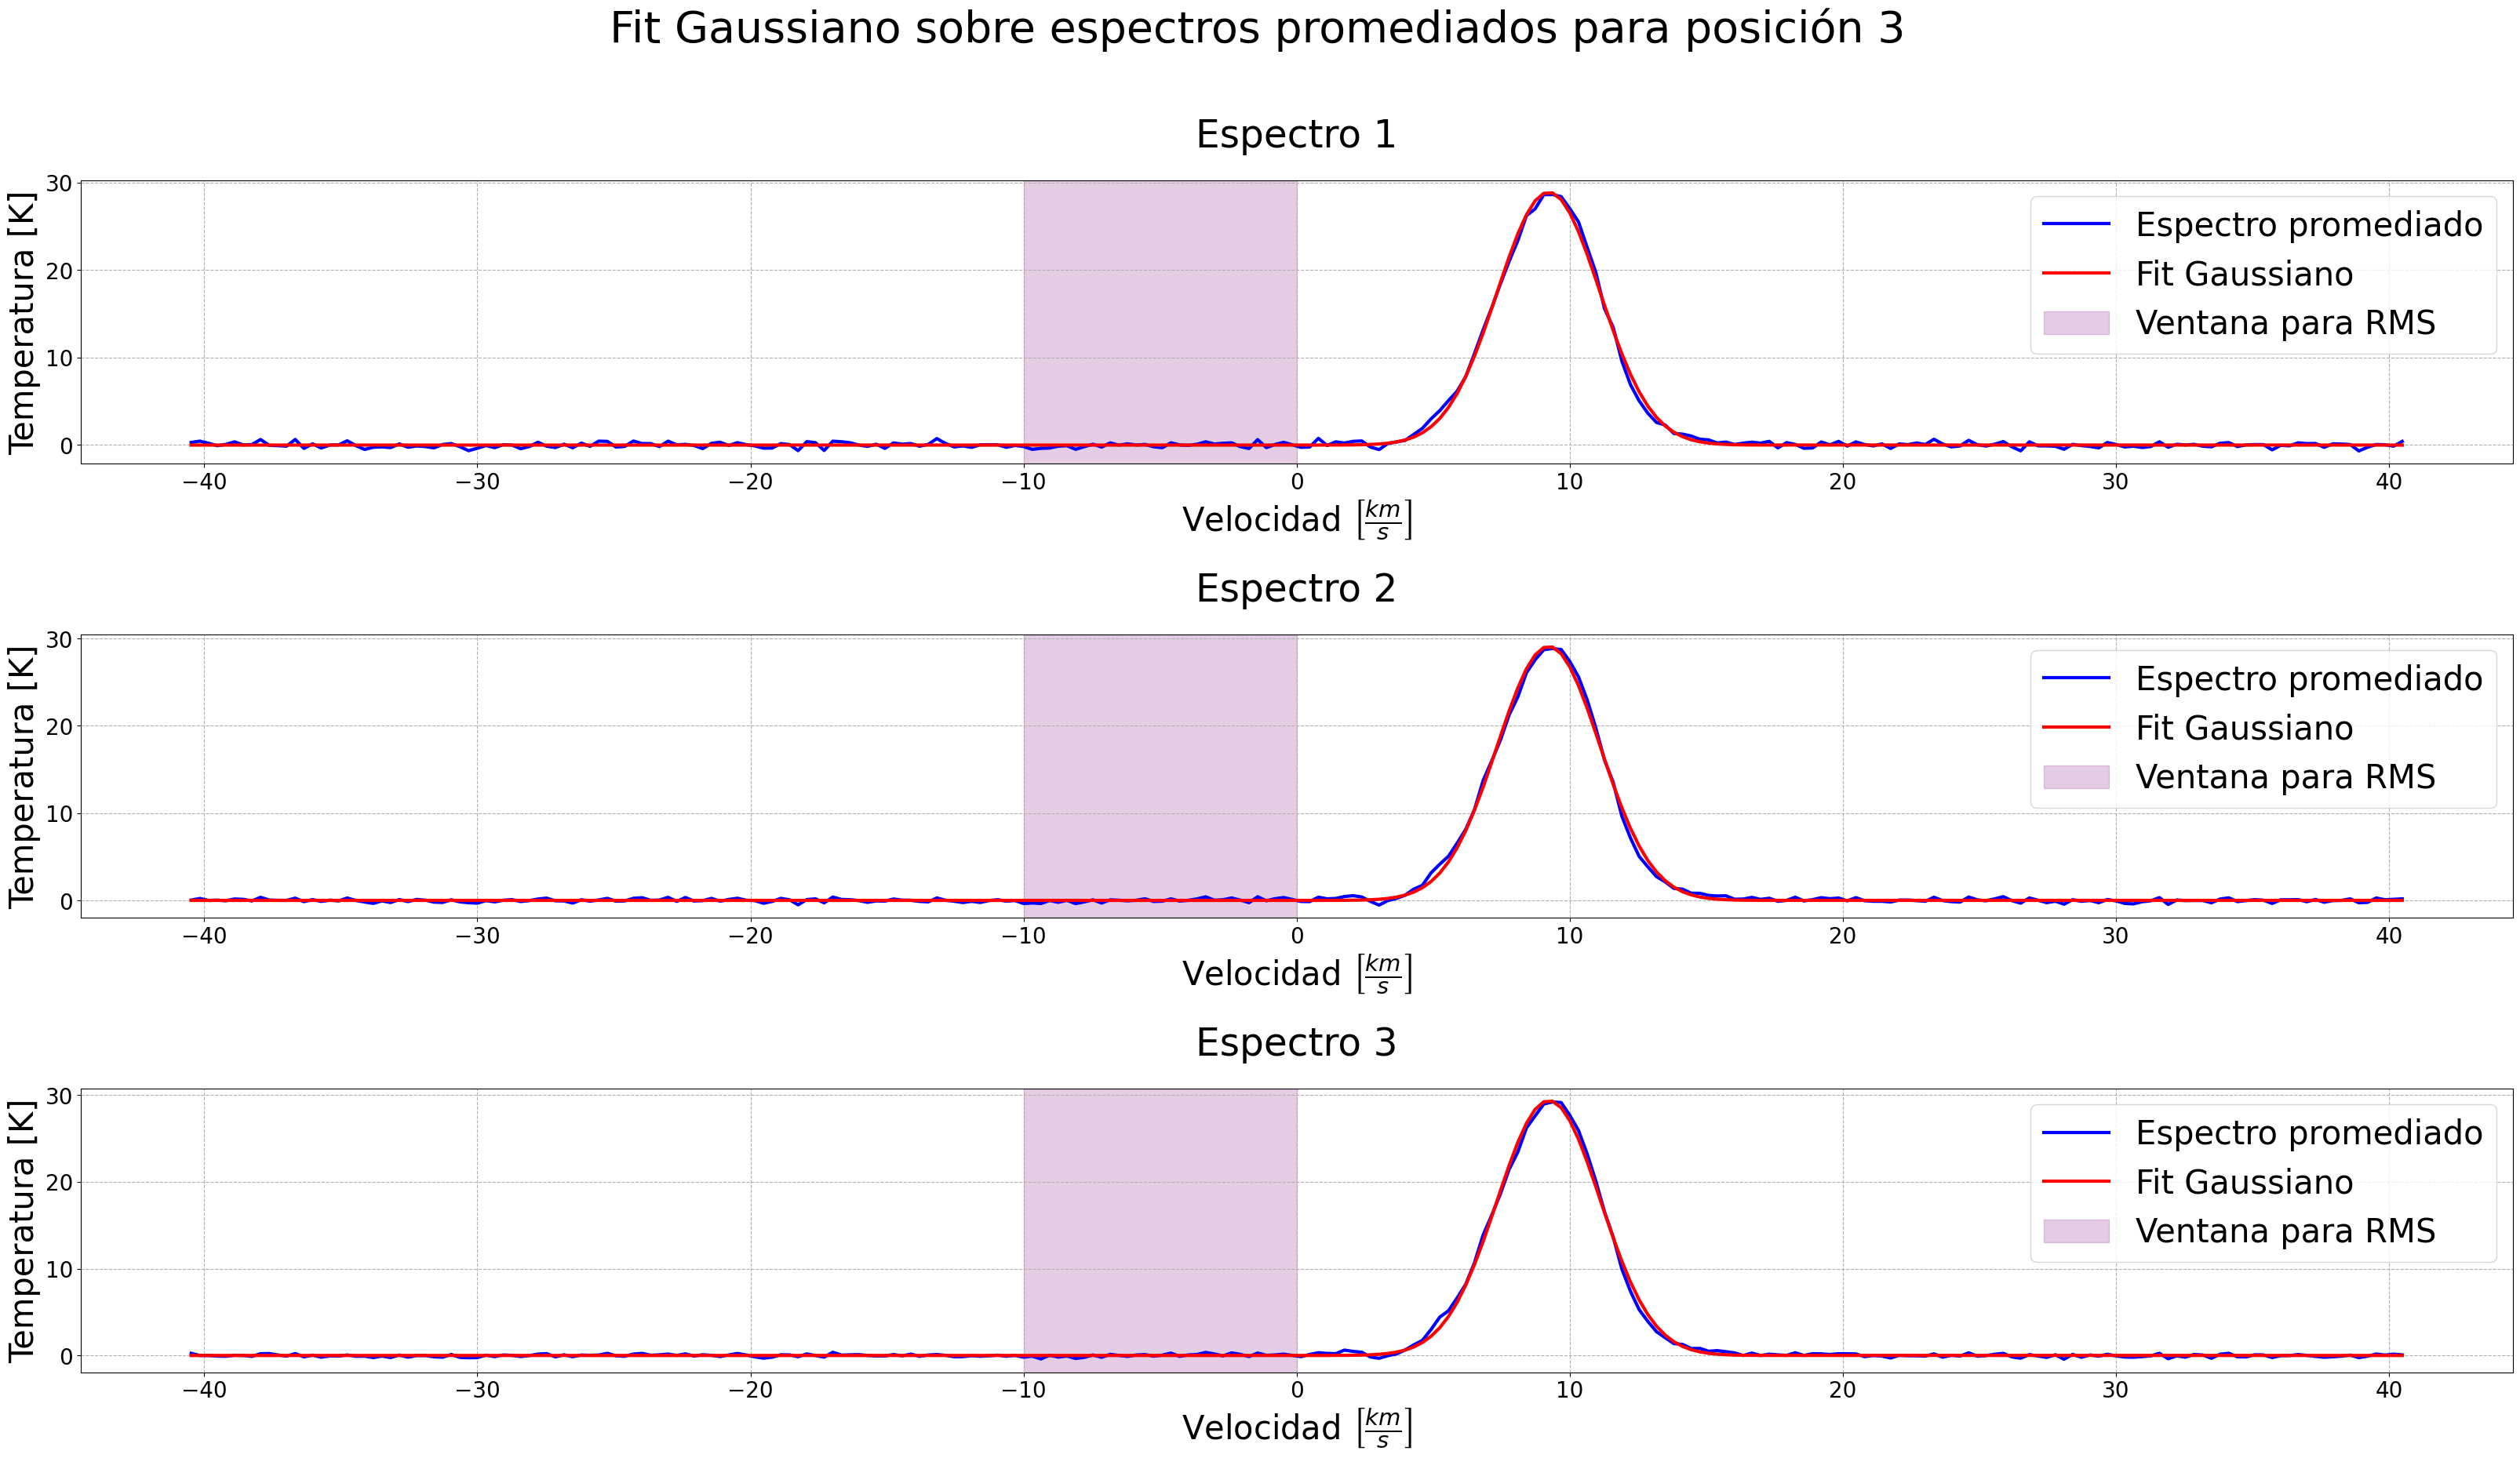

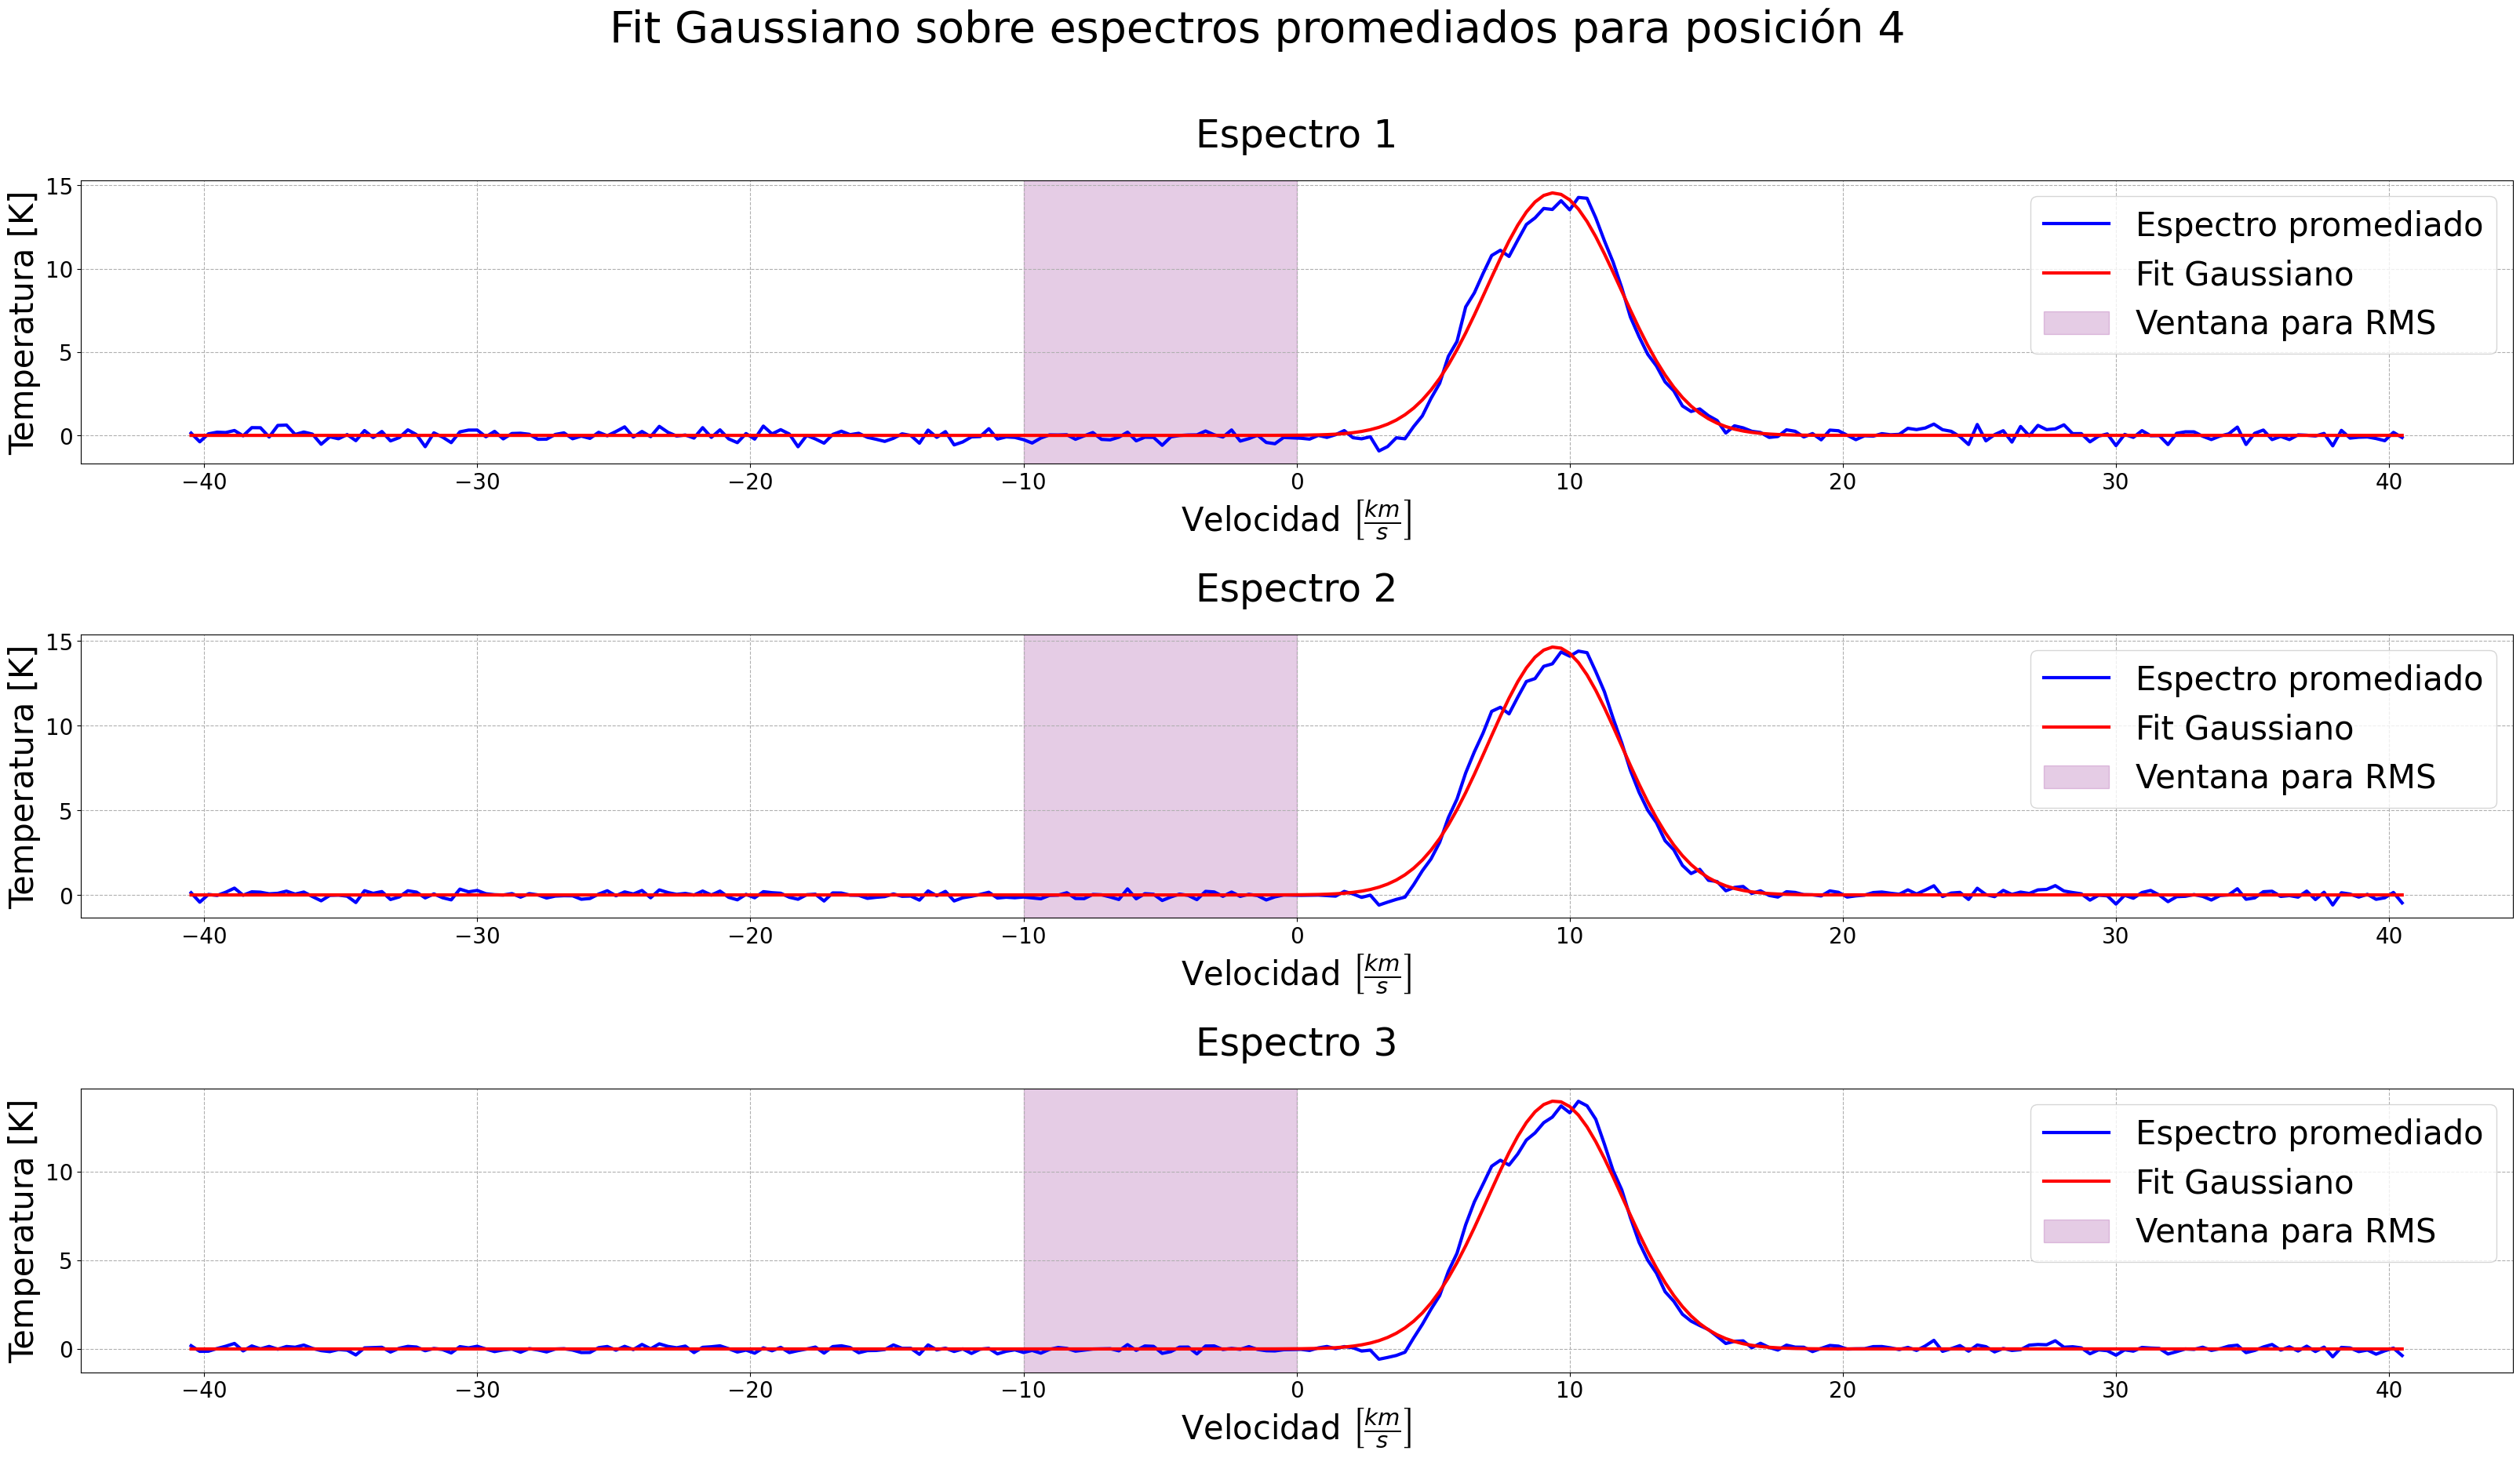

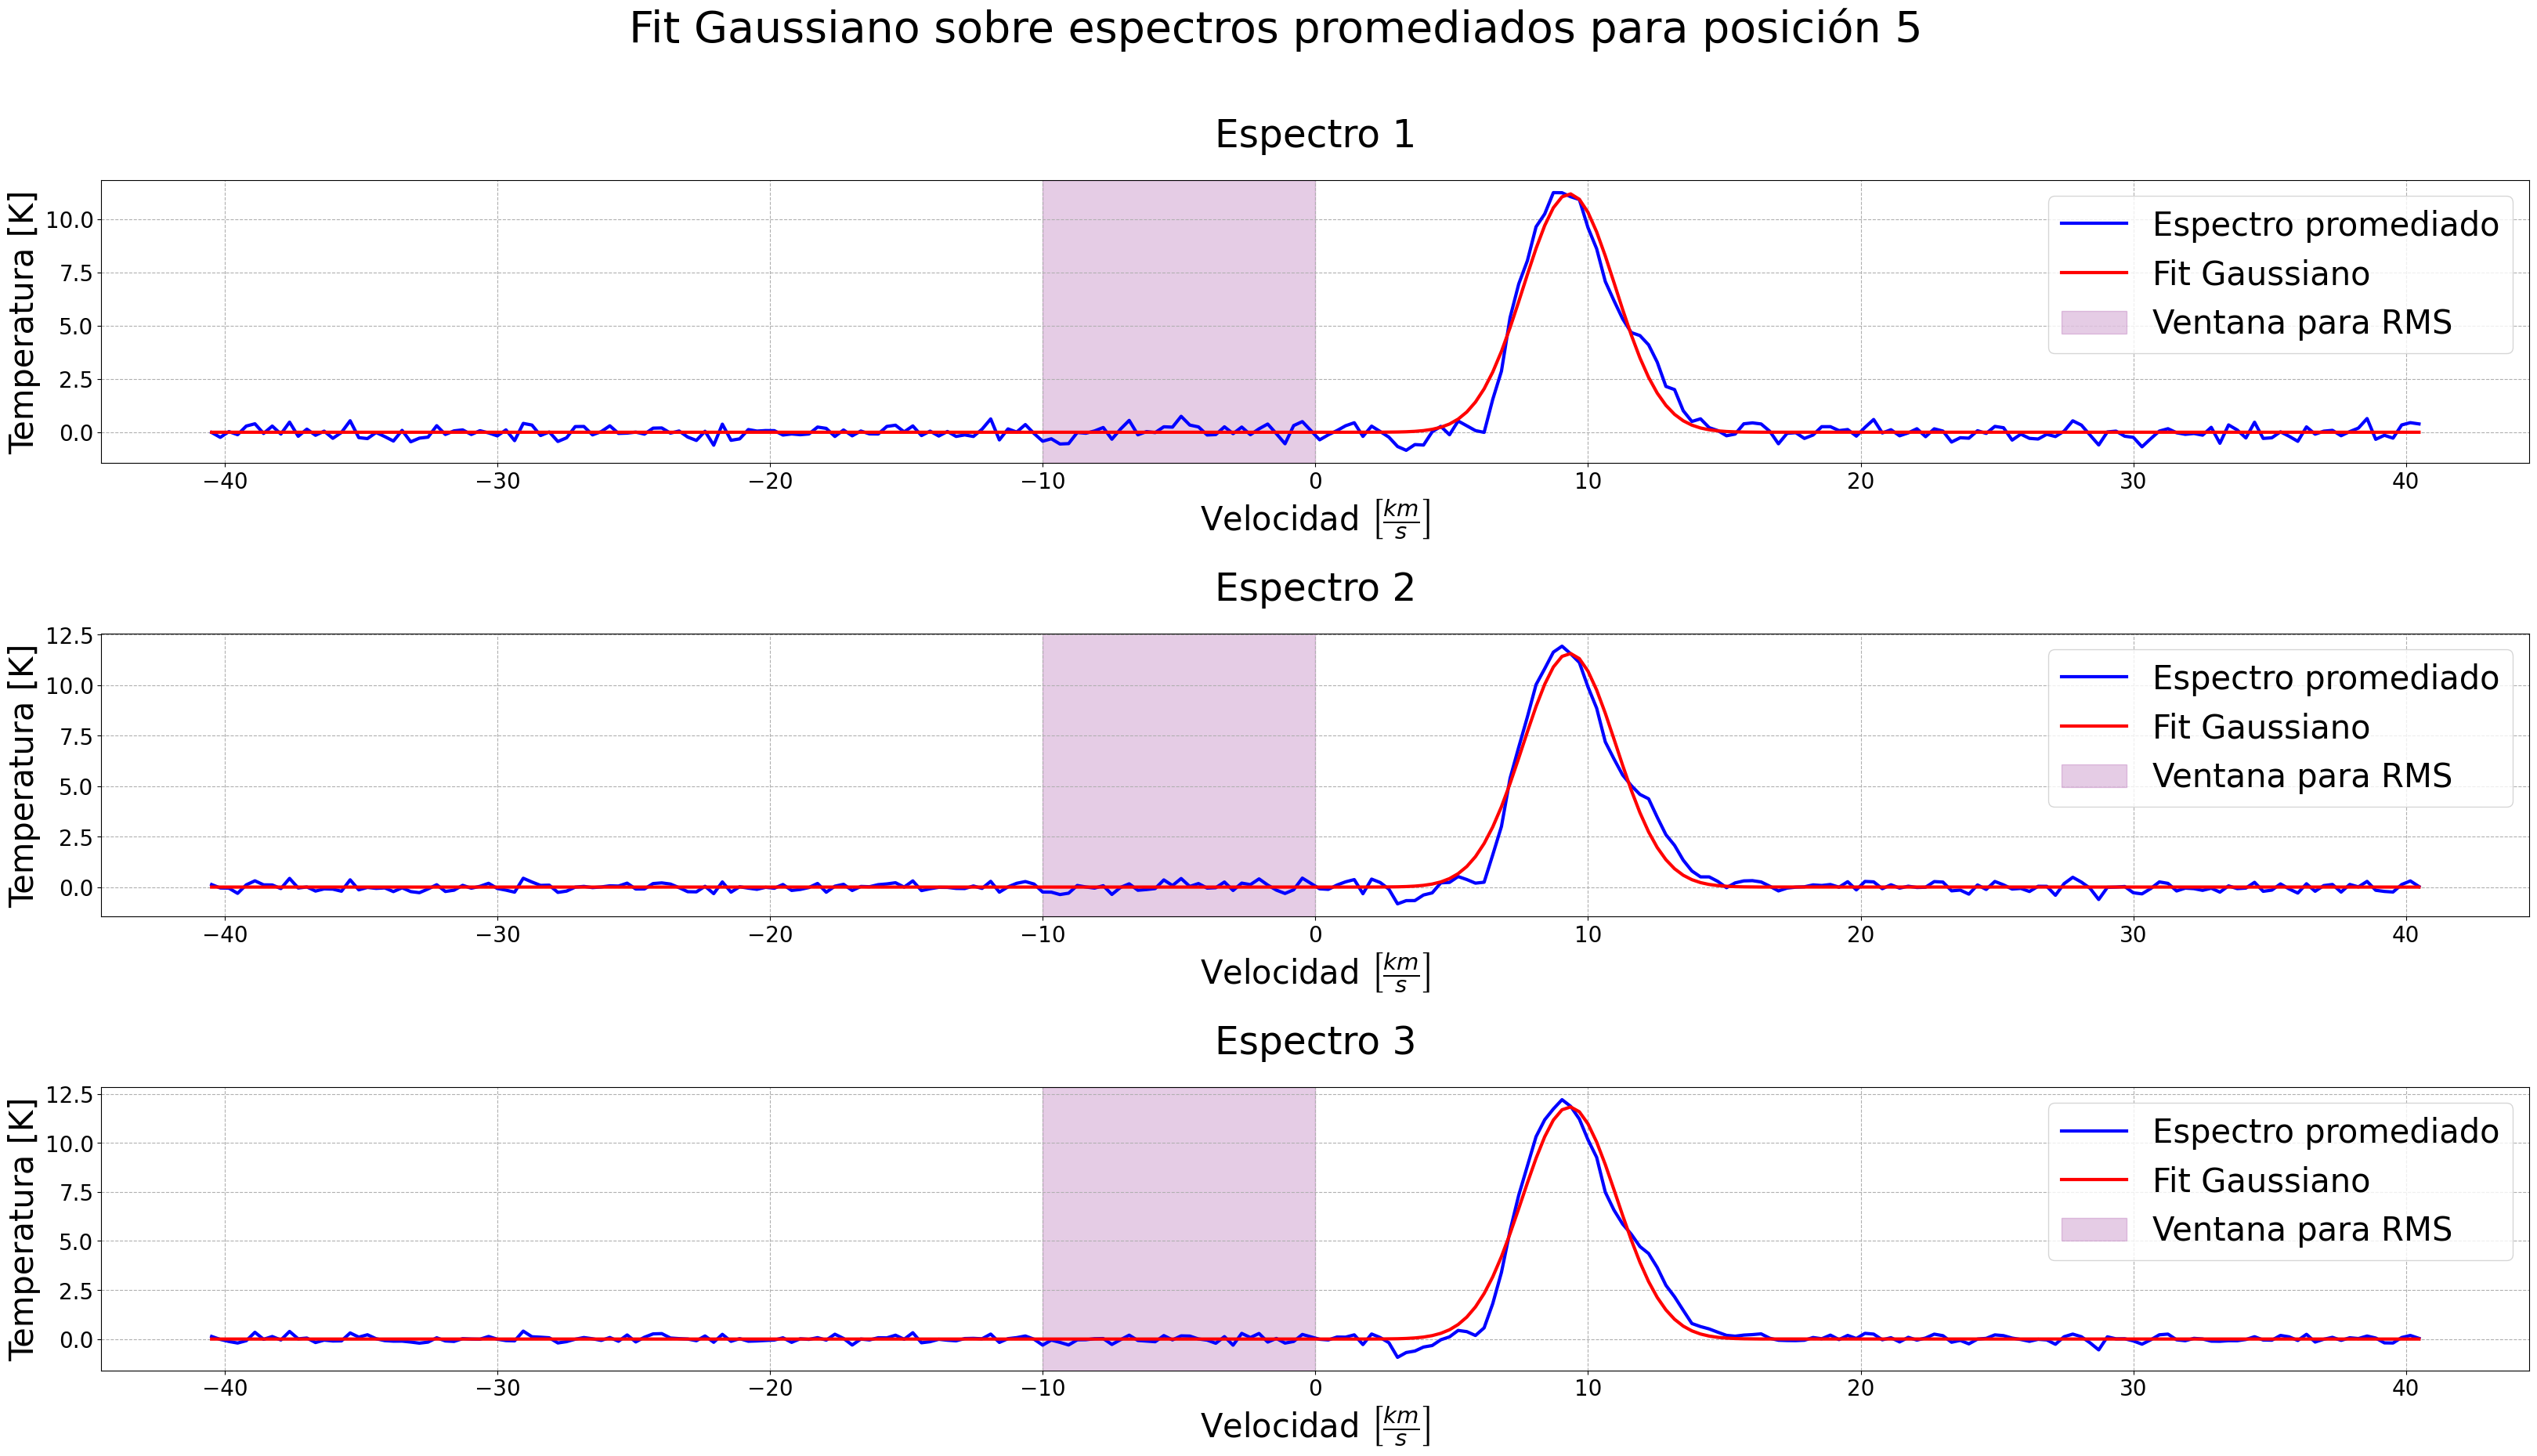

In [5]:
def fn_gauss(x, T0, mean, std):
    return T0*np.exp(-((x - mean)**2)/(2*(std**2)))

rms_pos_i = []
fg = [20, 10, 1]
mask = (v >= -10) & (v <= 0)

for k, i in enumerate(spec_vT_means):
    fig, axes = plt.subplots(3, 1, figsize = (40, 20))

    axes = axes.flatten()

    rms_pos = []
    for j, (v, T) in enumerate(i):
        coefs, cov = curve_fit(fn_gauss, v, T, p0 = fg)

        t0, M, S = coefs

        gauss_fit = fn_gauss(v, t0, M, S)

        resta = T - gauss_fit

        masked_resta  = resta[mask]

        rms_pos.append(np.std(masked_resta))

        axes[j].plot(v, T,
                     color = "blue",
                     linestyle = "-",
                     linewidth = 3,
                     label = 'Espectro promediado'
                     )
        axes[j].plot(v,
                     gauss_fit,
                     color = "red",
                     linestyle = "-",
                     linewidth = 3,
                     label = 'Fit Gaussiano'
                     )

        axes[j].set_xlabel(r"Velocidad $\left[ \frac{km}{s}\right]$",
                           fontsize = 30)
        axes[j].set_ylabel(r"Temperatura [K]",
                           fontsize = 30)

        axes[j].set_title('Espectro ' + (str(j + 1)), fontsize = 35, pad = 30)


        axes[j].axvspan(-10, 0, color='purple', alpha=0.2, label='Ventana para RMS')

        axes[j].grid(True, linestyle = "--", alpha = 1)
        axes[j].tick_params(labelsize = 20)
        axes[j].legend(fontsize = 30)

        fig.suptitle('Fit Gaussiano sobre espectros promediados para posición '
                     + str(k + 1), fontsize = 40, ha = 'center')

        fig.subplots_adjust(top = 0.87, hspace = 0.6)

    plt.show()
    rms_pos_i.append(rms_pos)

In [6]:
mean_pos_data = []

for i in spec_data:
    transposed = list(zip(*i))
    pos_mean = []
    for j in transposed:
        if type(j[0]) == float:
            mean = np.mean(j)
        else:
            stack = np.stack(j)
            mean = np.mean(j, axis = 0)
        pos_mean.append(mean)
    mean_pos_data.append(pos_mean)

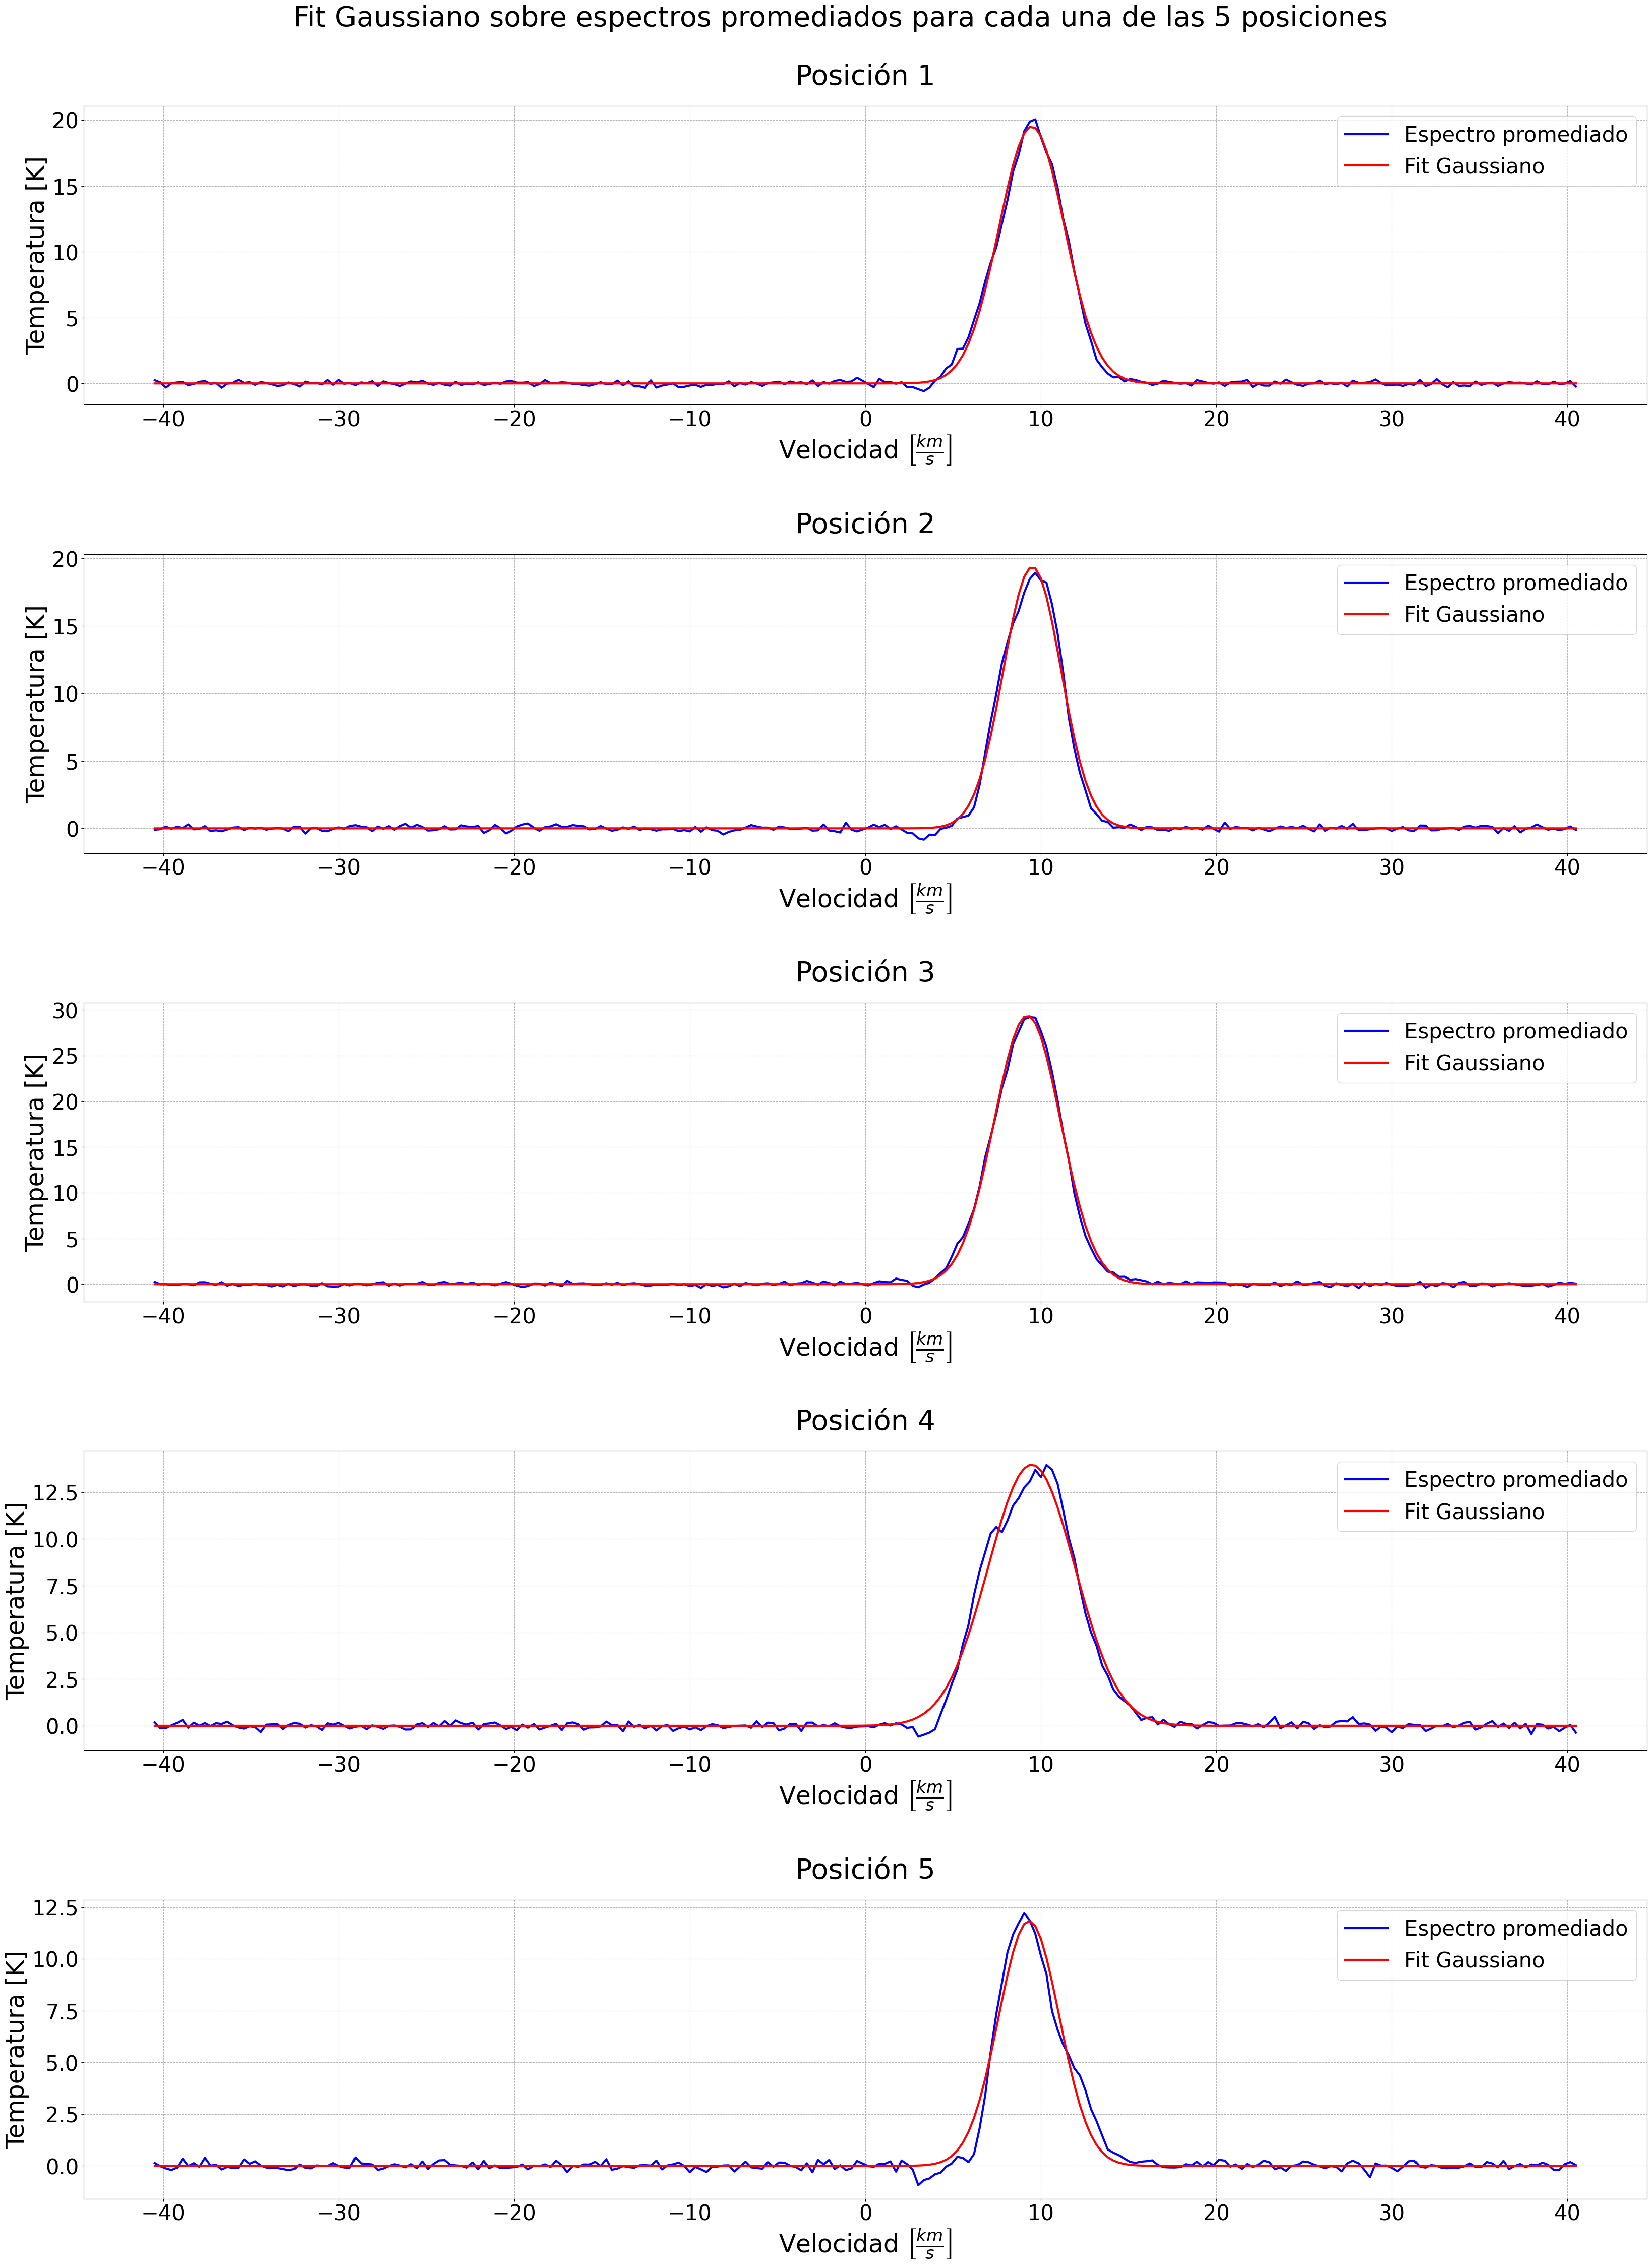

In [10]:
T_max = []

fig, axes = plt.subplots(5, 1, figsize = (40, 50))

axes = axes.flatten()

for k, i in enumerate(mean_pos_data):

    *coords, v, T = i

    fg = [20, 10, 1]

    coefs, cov = curve_fit(fn_gauss, v, T, p0=fg)

    t0, M, S = coefs[0], coefs[1], coefs[2]

    T_max.append(t0)

    gauss_fit = fn_gauss(v, t0, M, S)

    axes[k].plot(v, T, color = "blue", linestyle = "-", linewidth = 3, label = 'Espectro promediado')
    axes[k].plot(v, gauss_fit, color = "red", linestyle = "-", linewidth = 3, label = 'Fit Gaussiano')

    axes[k].set_xlabel(r"Velocidad $\left[ \frac{km}{s}\right]$", fontsize=35)
    axes[k].set_ylabel(r"Temperatura [K]", fontsize=35)

    axes[k].set_title('Posición ' + str(k + 1), fontsize = 40, pad = 30)

    axes[k].grid(True, linestyle = "--", alpha=0.9)
    axes[k].tick_params(labelsize = 30)
    axes[k].legend(fontsize = 30)

fig.suptitle('Fit Gaussiano sobre espectros promediados para cada una de las 5 posiciones', fontsize = 40, ha = 'center')

fig.subplots_adjust(top = 0.94, hspace = 0.5)
plt.show()

In [19]:
points = [(mean_pos_data[i][0], mean_pos_data[i][1]) for i in range(len(mean_pos_data))]

points = np.array(points)

T_max = np.array(T_max)

gridx, gridy = np.mgrid[208.84:209.14:300j, -19.52:-19.24:300j]

gridz = griddata(points, T_max, (gridx, gridy), method = 'cubic')

plt.figure(figsize = (20, 20), layout = 'tight')
plt.contourf(gridx, gridy, gridz, levels = 43, cmap = "hot")
cb = plt.colorbar(shrink = 0.8)
cb.set_label(label='Temperatura [K]', weight='bold', size = 15)
cb.ax.tick_params(labelsize = 15)
plt.contour(gridx, gridy, gridz, levels = 43, cmap = "magma_r")
plt.scatter(points[:, 0], points[:, 1], color = 'blue',
            label = 'Puntos de observación',
            zorder = 5)
plt.title("Mapa interpolado de contornos de $T_{max}$ para 5 puntos de observación",
          fontsize = 25,
          pad = 30)
plt.xlabel('Latitud galactica', fontsize = 25)
plt.ylabel('Longitud galactica', fontsize = 25)
plt.tick_params(labelsize = 15)
plt.gca().set_aspect('equal', adjustable = 'box')
plt.grid(True, linestyle = '-', alpha = 0.3, color = 'k')
plt.legend(fontsize = 20)
plt.show()

In [22]:
T_int = []
for i in mean_pos_data:
    T_int.append(np.trapezoid(i[2], i[3]))

T_int = np.array(T_int)

gridzint = griddata(points, T_int, (gridx, gridy), method = 'cubic')

plt.figure(figsize = (20, 20), layout = 'tight')
plt.contourf(gridx, gridy, gridzint, levels = 43, cmap = "hot")
cb = plt.colorbar(shrink = 0.8)
cb.set_label(label='Temperatura [K]', size = 15)
cb.ax.tick_params(labelsize = 15)
plt.contour(gridx, gridy, gridzint, levels = 43, cmap = "magma_r")
plt.scatter(points[:, 0], points[:, 1], color = 'blue',
            label = 'Coordenadas de observación',
            zorder = 5)
plt.title('Mapa interpolado de contornos de $T_{int}$ para 5 puntos de observación',
          fontsize = 25,
          pad = 30)

plt.xlabel('Latitud Galactica', fontsize = 25)
plt.ylabel('Longitud Galactica', fontsize = 25)
plt.tick_params(labelsize = 15)
plt.gca().set_aspect('equal', adjustable = 'box')
plt.grid(True, linestyle = '-', alpha = 0.3, color = 'k')
plt.legend(fontsize = 20)

plt.show()